In [1]:
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats  # box-cox变换
# 线性回归
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
# 网格调参
from sklearn.model_selection import GridSearchCV
# 回归树
from sklearn.tree import DecisionTreeRegressor
# 随机森林
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

C:\Users\qq152\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 导入数据
https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

In [2]:
data = pd.read_csv("SeoulBikeData.csv")
data.head()

,Date,RentedBikeCount,Hour,Temperature,Humidity,WindSpeed,Visibility,DewPointTemperature,SolarRadiation,Rainfall,Snowfall,Seasons,Holiday,FunctioningDay
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,NoHoliday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,NoHoliday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,NoHoliday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,NoHoliday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,NoHoliday,Yes


In [3]:
data.describe()

,RentedBikeCount,Hour,Temperature,Humidity,WindSpeed,Visibility,DewPointTemperature,SolarRadiation,Rainfall,Snowfall
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 8760 non-null   object 
 1   RentedBikeCount      8760 non-null   int64  
 2   Hour                 8760 non-null   int64  
 3   Temperature          8760 non-null   float64
 4   Humidity             8760 non-null   int64  
 5   WindSpeed            8760 non-null   float64
 6   Visibility           8760 non-null   int64  
 7   DewPointTemperature  8760 non-null   float64
 8   SolarRadiation       8760 non-null   float64
 9   Rainfall             8760 non-null   float64
 10  Snowfall             8760 non-null   float64
 11  Seasons              8760 non-null   object 
 12  Holiday              8760 non-null   object 
 13  FunctioningDay       8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ KB


In [5]:
data.columns

Index(['Date', 'RentedBikeCount', 'Hour', 'Temperature', 'Humidity',
       'WindSpeed', 'Visibility', 'DewPointTemperature', 'SolarRadiation',
       'Rainfall', 'Snowfall', 'Seasons', 'Holiday', 'FunctioningDay'],
      dtype='object')

In [6]:
## 缺失值和对数变量可行性检查
class DataPreprocessor:
    def __init__(self, data, target_column):
        self.data = data
        self.target_column = target_column

    def check_missing_values(self):
        """检查数据集中的缺失值"""
        missing_values = self.data.isnull().sum()
        print("缺失值统计：")
        print(missing_values)

    def check_zero_values(self):
        """检查因变量中是否存在零值"""
        zero_values = self.data[self.target_column] == 0
        if zero_values.sum() > 0:
            print(f"警告：因变量 {self.target_column} 中存在 {zero_values.sum()} 个零值")
        return zero_values

    def log_transform(self):
        """对因变量进行对数变换，处理零值"""
        # 检查因变量中是否存在零值
        zero_values = self.check_zero_values()

        # 如果因变量有零值，发出警告并返回原数据
        if zero_values.sum() > 0:
            warnings.warn(f"因变量 {self.target_column} 包含零值，无法进行对数变换。请注意，零值可能会影响模型拟合。", UserWarning)
            return self.data  # 返回原始数据，不做对数变换
        
        # 如果没有零值，进行对数变换
        self.data[self.target_column] = np.log(self.data[self.target_column])
        print(f"对因变量 {self.target_column} 进行了对数变换。")
        return self.data

data_check = data.copy()
check = DataPreprocessor(data_check, 'RentedBikeCount')
check.check_missing_values()
check.log_transform()

缺失值统计：
Date                   0
RentedBikeCount        0
Hour                   0
Temperature            0
Humidity               0
WindSpeed              0
Visibility             0
DewPointTemperature    0
SolarRadiation         0
Rainfall               0
Snowfall               0
Seasons                0
Holiday                0
FunctioningDay         0
dtype: int64
警告：因变量 RentedBikeCount 中存在 295 个零值


C:\Users\qq152\AppData\Local\Temp\ipykernel_26972\4128767530.py:27: UserWarning: 因变量 RentedBikeCount 包含零值，无法进行对数变换。请注意，零值可能会影响模型拟合。
  warnings.warn(f"因变量 {self.target_column} 包含零值，无法进行对数变换。请注意，零值可能会影响模型拟合。", UserWarning)


,Date,RentedBikeCount,Hour,Temperature,Humidity,WindSpeed,Visibility,DewPointTemperature,SolarRadiation,Rainfall,Snowfall,Seasons,Holiday,FunctioningDay
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,NoHoliday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,NoHoliday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,NoHoliday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,NoHoliday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,NoHoliday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,NoHoliday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,NoHoliday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,NoHoliday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,NoHoliday,Yes


## 数据处理&描述性分析

In [7]:
## 将日期转为date类型
date_obj = data['Date']  ## datetime类型
date_col = pd.to_datetime(data['Date'],format='%d/%m/%Y')
data['Date'] = date_col
data['Date'] = data['Date'].dt.date  ## object类型
data.Date

0       2017-12-01
1       2017-12-01
2       2017-12-01
3       2017-12-01
4       2017-12-01
           ...    
8755    2018-11-30
8756    2018-11-30
8757    2018-11-30
8758    2018-11-30
8759    2018-11-30
Name: Date, Length: 8760, dtype: object

In [8]:
## 加入变量weekday or weekend
data['week'] = date_col.dt.dayofweek
data['week'] = data['week'].apply(lambda x:'weekday' if x < 5  else 'weekend')

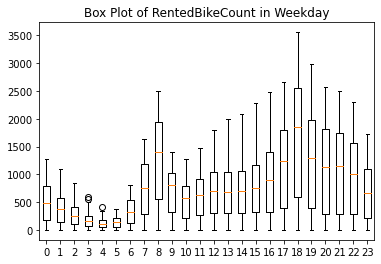

In [9]:
## 周内RentedBikeCount不同时刻箱线图
weekday_data = data[data['week'] == 'weekday']
hours = data['Hour'].unique()
Y_hour = [weekday_data[weekday_data['Hour'] == hour]['RentedBikeCount'].values for hour in hours]
plt.boxplot(Y_hour, labels = hours)
plt.title('Box Plot of RentedBikeCount in Weekday')
plt.savefig("./boxplot1.jpg")
plt.show()

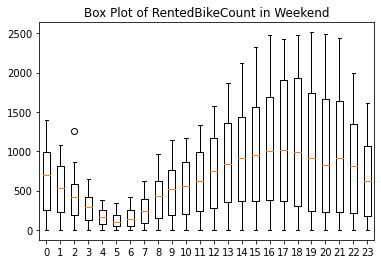

In [10]:
## 周末RentedBikeCount不同时刻箱线图
weekend_data = data[data['week'] == 'weekend']
hours = data['Hour'].unique()
Y_hour = [weekend_data[weekend_data['Hour'] == hour]['RentedBikeCount'].values for hour in hours]
plt.boxplot(Y_hour, labels = hours)
plt.title('Box Plot of RentedBikeCount in Weekend')
plt.savefig("./boxplot2.jpg")
plt.show()

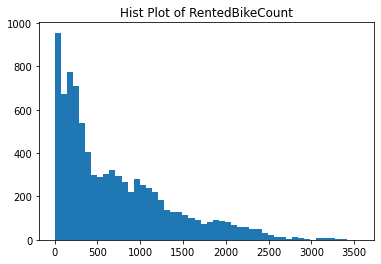

In [11]:
# Y的分布
y = data['RentedBikeCount']
plt.hist(y, bins = 50)
plt.title('Hist Plot of RentedBikeCount')
plt.savefig("./hist1.jpg")
plt.show()

In [12]:
## 截取前三个月的数据
data_month = data.iloc[:(24*90),:]
data_month.columns

Index(['Date', 'RentedBikeCount', 'Hour', 'Temperature', 'Humidity',
       'WindSpeed', 'Visibility', 'DewPointTemperature', 'SolarRadiation',
       'Rainfall', 'Snowfall', 'Seasons', 'Holiday', 'FunctioningDay', 'week'],
      dtype='object')

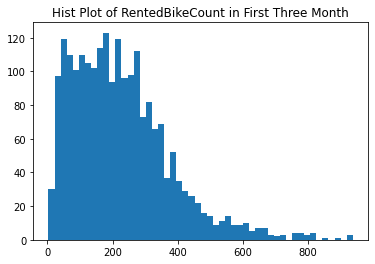

In [13]:
## hist of RentedBikeCount（前三个月）
plt.hist(data_month['RentedBikeCount'], bins = 50)
plt.title('Hist Plot of RentedBikeCount in First Three Month')
plt.savefig("./hist2.jpg")
plt.show()

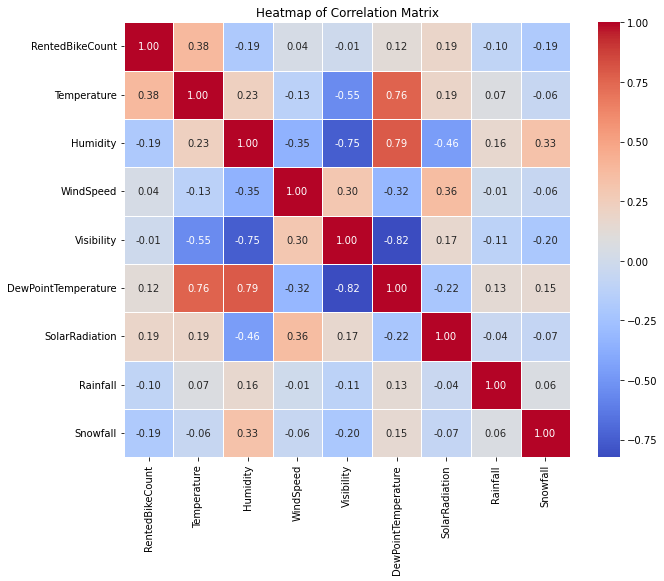

In [14]:
## count与连续型自变量相关性热力图
con_list = [1] + list(range(3, 11))
continuous = data_month.iloc[:, con_list]
corr_matrix = continuous.corr()  # 计算变量间的相关性矩阵b
# 绘制热力图
plt.figure(figsize=(10, 8))  # 设置图像大小
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)
# 设置标题
plt.title('Heatmap of Correlation Matrix')
# 显示热力图
plt.savefig("./heat.jpg")
plt.show()

In [15]:
## 筛选删除相关性高的自变量
data_choose = data_month.copy()
data_choose.drop(columns=['Date', 'DewPointTemperature', 'Seasons', 'FunctioningDay'], inplace=True)
data_choose.head()

,RentedBikeCount,Hour,Temperature,Humidity,WindSpeed,Visibility,SolarRadiation,Rainfall,Snowfall,Holiday,week
0,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,NoHoliday,weekday
1,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,NoHoliday,weekday
2,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,NoHoliday,weekday
3,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,NoHoliday,weekday
4,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,NoHoliday,weekday


In [16]:
## 连续型自变量归一化
data_scale = data_choose.copy()
col_norm = (data_choose.iloc[:, 2:9] - data_choose.iloc[:, 2:9].mean()) / (data_choose.iloc[:, 2:9].std())
data_scale.iloc[:, 2:9] = col_norm
data_scale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RentedBikeCount  2160 non-null   int64  
 1   Hour             2160 non-null   int64  
 2   Temperature      2160 non-null   float64
 3   Humidity         2160 non-null   float64
 4   WindSpeed        2160 non-null   float64
 5   Visibility       2160 non-null   float64
 6   SolarRadiation   2160 non-null   float64
 7   Rainfall         2160 non-null   float64
 8   Snowfall         2160 non-null   float64
 9   Holiday          2160 non-null   object 
 10  week             2160 non-null   object 
dtypes: float64(7), int64(2), object(2)
memory usage: 185.8+ KB


0.3844137359886479


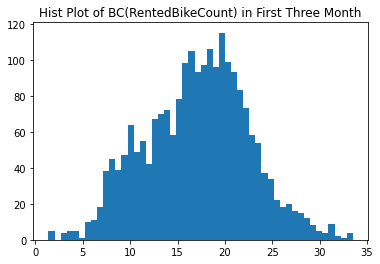

In [17]:
## 模型用数据
data_model = data_scale

## BOX-COX变换
data_bc = data_model.copy()
transformed_data, lambda_value = stats.boxcox(data_model['RentedBikeCount'])
data_bc['RentedBikeCount'] = transformed_data
print(lambda_value)

## hist of RentedBikeCount（前三个月）
plt.hist(data_bc['RentedBikeCount'], bins = 50)
plt.title('Hist Plot of BC(RentedBikeCount) in First Three Month')
plt.savefig("./hist3.jpg")
plt.show()

In [18]:
data_model.head()

,RentedBikeCount,Hour,Temperature,Humidity,WindSpeed,Visibility,SolarRadiation,Rainfall,Snowfall,Holiday,week
0,254,0,-0.486225,-0.660253,0.239886,0.872659,-0.56987,-0.077685,-0.354397,NoHoliday,weekday
1,204,1,-0.541072,-0.608448,-0.971158,0.872659,-0.56987,-0.077685,-0.354397,NoHoliday,weekday
2,173,2,-0.632484,-0.556643,-0.798151,0.872659,-0.56987,-0.077685,-0.354397,NoHoliday,weekday
3,107,3,-0.669049,-0.504838,-0.884654,0.872659,-0.56987,-0.077685,-0.354397,NoHoliday,weekday
4,78,4,-0.632484,-0.712059,0.326389,0.872659,-0.56987,-0.077685,-0.354397,NoHoliday,weekday


In [19]:
data_bc.head()

,RentedBikeCount,Hour,Temperature,Humidity,WindSpeed,Visibility,SolarRadiation,Rainfall,Snowfall,Holiday,week
0,19.258740,0,-0.486225,-0.660253,0.239886,0.872659,-0.56987,-0.077685,-0.354397,NoHoliday,weekday
1,17.492093,1,-0.541072,-0.608448,-0.971158,0.872659,-0.56987,-0.077685,-0.354397,NoHoliday,weekday
2,16.258422,2,-0.632484,-0.556643,-0.798151,0.872659,-0.56987,-0.077685,-0.354397,NoHoliday,weekday
3,13.077843,3,-0.669049,-0.504838,-0.884654,0.872659,-0.56987,-0.077685,-0.354397,NoHoliday,weekday
4,11.283712,4,-0.632484,-0.712059,0.326389,0.872659,-0.56987,-0.077685,-0.354397,NoHoliday,weekday


In [20]:
# ## 一周之内每天的RentedBikeCount-Hour（2017-12第一周）
# date = data.Date
# date_uniq = date.unique()
# # 前三
# fig, axs = plt.subplots(1, 3, figsize=(12.5, 4.2))
# for i in range(3):
#     date_i = date_uniq[i]
#     data_i = data[data['Date']==date_i][['RentedBikeCount', 'Hour']]
#     axs[i].plot(data_i['Hour'], data_i['RentedBikeCount'])
#     axs[i].set_title('Rented Bike Count of {date}'.format(date = date_i))
# # 后四
# fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# for i in range(3,7):
#     date_i = date_uniq[i]
#     data_i = data[data['Date']==date_i][['RentedBikeCount', 'Hour']]
#     axs[i-3].plot(data_i['Hour'], data_i['RentedBikeCount'])
#     axs[i-3].set_title('Rented Bike Count of {date}'.format(date = date_i))
# plt.show()

In [21]:
# ## 一周之内每天的RentedBikeCount-Hour（2017-12第二周）
# date = data.Date
# date_uniq = date.unique()
# # 前三
# fig, axs = plt.subplots(1, 3, figsize=(12.5, 4.2))
# for i in range(3):
#     date_i = date_uniq[i+7]
#     data_i = data[data['Date']==date_i][['RentedBikeCount', 'Hour']]
#     axs[i].plot(data_i['Hour'], data_i['RentedBikeCount'])
#     axs[i].set_title('Rented Bike Count of {date}'.format(date = date_i))
# plt.show()
# # 后四
# fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# for i in range(3,7):
#     date_i = date_uniq[i+7]
#     data_i = data[data['Date']==date_i][['RentedBikeCount', 'Hour']]
#     axs[i-3].plot(data_i['Hour'], data_i['RentedBikeCount'])
#     axs[i-3].set_title('Rented Bike Count of {date}'.format(date = date_i))
# plt.show()

In [22]:
# ## 不同星期的RentedBikeCount-Hour
# # 前三
# fig, axs = plt.subplots(1, 3, figsize=(12.5, 4.2))
# for i in range(3):
#     data_i = data[data['week']==i][['RentedBikeCount', 'Hour']]
#     axs[i].scatter(data_i['Hour'], data_i['RentedBikeCount'])
# axs[0].set_title('Rented Bike Count of Monday')
# axs[1].set_title('Rented Bike Count of Tuesday')
# axs[2].set_title('Rented Bike Count of Wednesday')
# plt.show()
# # 后四
# fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# for i in range(3,7):
#     data_i = data[data['week']==i][['RentedBikeCount', 'Hour']]
#     axs[i-3].scatter(data_i['Hour'], data_i['RentedBikeCount'])
# axs[0].set_title('Rented Bike Count of Thursday')
# axs[1].set_title('Rented Bike Count of Friday')
# axs[2].set_title('Rented Bike Count of Saturday')
# axs[3].set_title('Rented Bike Count of Sunday')
# plt.show()

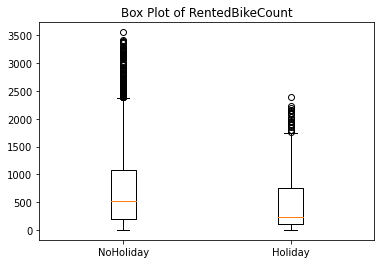

In [23]:
# ## Y-分类变量箱线图（Season, Holiday, FunctioningDay)
# ## Y-Season
# seasons = data['Seasons'].unique()
# Y_season = [data[data['Seasons'] == season]['RentedBikeCount'].values for season in seasons]
# plt.boxplot(Y_season, labels = seasons)
# plt.show()

## Y-Holiday
holidays = data['Holiday'].unique()
Y_holiday = [data[data['Holiday'] == holiday]['RentedBikeCount'].values for holiday in holidays]
plt.boxplot(Y_holiday, labels = holidays)
plt.title('Box Plot of RentedBikeCount')
plt.savefig("./box_holiday.jpg")
plt.show()

In [24]:
# # Y-连续变量相关图
# data_corr = pd.concat([data_norm.iloc[:, 1], data_norm.iloc[:, 3:11]], axis = 1)
# # data_corr = data_norm.iloc[:, 3:11]
# data_corr
# sns.pairplot(data_corr)

In [25]:
data_bc.to_csv("newdata.csv")

## 回归分析

#### 泊松回归

In [26]:
# data_dummy = pd.get_dummies(data_model, drop_first=True)  #类别型(category)，删除第一列避免共线性
# data_dummy.head()
# # data_dummy.columns
# # data.shape

In [27]:
# formula = 'RentedBikeCount ~ ' + ' + '.join(data_dummy.iloc[:, 1:].columns)
# model_LR = smf.poisson(formula, data=data_dummy)
# results = model_LR.fit()   #拟合
# results.summary()

#### 线性回归

In [28]:
data_dummy_bc = pd.get_dummies(data_bc, drop_first=True)  #类别型(category)，删除第一列避免共线性
data_dummy_bc.head()
# data_dummy.columns
# data.shape

,RentedBikeCount,Hour,Temperature,Humidity,WindSpeed,Visibility,SolarRadiation,Rainfall,Snowfall,Holiday_NoHoliday,week_weekend
0,19.258740,0,-0.486225,-0.660253,0.239886,0.872659,-0.56987,-0.077685,-0.354397,1,0
1,17.492093,1,-0.541072,-0.608448,-0.971158,0.872659,-0.56987,-0.077685,-0.354397,1,0
2,16.258422,2,-0.632484,-0.556643,-0.798151,0.872659,-0.56987,-0.077685,-0.354397,1,0
3,13.077843,3,-0.669049,-0.504838,-0.884654,0.872659,-0.56987,-0.077685,-0.354397,1,0
4,11.283712,4,-0.632484,-0.712059,0.326389,0.872659,-0.56987,-0.077685,-0.354397,1,0


In [29]:
# formula = 'RentedBikeCount ~ ' + ' + '.join(data_dummy_bc.iloc[:, 1:].columns)
# model_LR = smf.ols(formula, data=data_dummy_bc)
# results = model_LR.fit()   #拟合
# results.summary()

In [30]:
## 变量选择
def stepwise_selection(data, response_variable, max_iter=100):
    # 获取所有的自变量
    initial_features = data.columns.tolist()
    initial_features.remove(response_variable)
    
    best_model = None
    best_aic = float('inf')
    selected_features = []
    
    for _ in range(max_iter):
        aic_values = {}
        
        # 向前选择和向后删除变量，查看所有可能的模型
        for feature in initial_features:
            # 用当前特征构建模型
            formula = f'{response_variable} ~ ' + ' + '.join(selected_features + [feature])
            model = smf.ols(formula, data=data).fit()
            aic_values[feature] = model.aic
        
        # 找到最小 AIC 的特征
        best_feature = min(aic_values, key=aic_values.get)
        
        if aic_values[best_feature] < best_aic:
            best_aic = aic_values[best_feature]
            selected_features.append(best_feature)
            initial_features.remove(best_feature)
        else:
            # 如果添加新特征不能改善 AIC，则退出
            break
    
    # 计算最终模型
    final_formula = f'{response_variable} ~ ' + ' + '.join(selected_features)
    best_model = smf.ols(final_formula, data=data).fit()
    
    return best_model

In [31]:
# 划分训练集和测试集
train, test = train_test_split(data_dummy_bc, test_size=0.3, random_state=42)

# 使用训练集拟合线性回归模型（假设你用 smf.ols 建立模型）
formula = 'RentedBikeCount ~ ' + ' + '.join(data_dummy_bc.iloc[:, 1:].columns)

# 使用逐步回归选择自变量并训练模型
response_variable = 'y'  # 替换为你的因变量名
best_model = stepwise_selection(train, 'RentedBikeCount')

# 打印最优模型的摘要
print(best_model.summary())

# 用测试集的数据进行预测
y_test = test['RentedBikeCount']
X_test = test.iloc[:, 1:]  # 请根据实际情况修改
y_pred = best_model.predict(test)

# 计算 MSE（均方误差）
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

# 计算 R²（决定系数）
r_squared = r2_score(y_test, y_pred)
print(f'R²: {r_squared}')

                            OLS Regression Results                            
Dep. Variable:        RentedBikeCount   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     129.4
Date:                Thu, 02 Jan 2025   Prob (F-statistic):          3.73e-180
Time:                        22:50:38   Log-Likelihood:                -4300.3
No. Observations:                1512   AIC:                             8621.
Df Residuals:                    1502   BIC:                             8674.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            11.5504      0.41

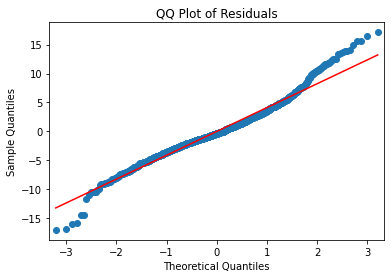

In [32]:
## QQplot
residuals = best_model.resid
qqplot(residuals, line = 'r')
plt.title('QQ Plot of Residuals')
plt.savefig("./QQ.jpg")
plt.show()

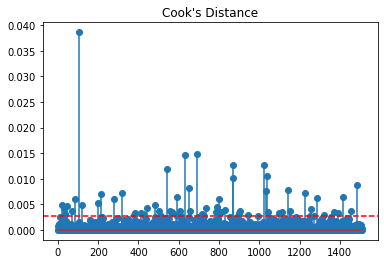

In [33]:
influence = best_model.get_influence()
cooks_d = influence.cooks_distance[0]

# 绘制Cook's距离
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt="o")
threshold = 4 / len(train)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Critical Value (4/n) = {threshold:.3f}')
plt.title("Cook's Distance")
plt.savefig("./cook.jpg")
plt.show()

## 回归树

In [34]:
# # 划分训练集和测试集
# X = data_dummy_bc.iloc[:, 1:]
# y = data_dummy_bc.iloc[:, 0]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # 创建决策树回归模型
# dt_model = DecisionTreeRegressor()

# # 训练模型
# dt_model.fit(X_train, y_train)

# # 预测
# y_pred_dt = dt_model.predict(X_test)

# # 计算MSE
# mse_dt = mean_squared_error(y_test, y_pred_dt)
# print(f"Decision Tree Model Mean Squared Error: {mse_dt}")
# r2 = r2_score(y_test, y_pred)
# print(f'R-squared: {r2}')

In [35]:
## 网格调参
# 划分训练集和测试集
X = data_dummy_bc.iloc[:, 1:]
y = data_dummy_bc.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 定义回归树模型
dt = DecisionTreeRegressor(random_state=42)

# 定义超参数网格
param_grid = {
    'max_depth': [3, 5, 10, None],               # 最大深度
    'min_samples_split': [2, 5, 10],             # 最小样本划分数
    'min_samples_leaf': [1, 2, 5],               # 最小样本叶子数
    'max_features': [None, 'auto', 'sqrt', 'log2'],  # 最大特征数
}

# 初始化网格搜索
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# 训练模型
grid_search.fit(X_train, y_train)

# 打印最佳参数组合
print(f"最佳参数组合: {grid_search.best_params_}")

# 使用最佳模型进行预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 计算MSE
mse = mean_squared_error(y_test, y_pred)
print(f"测试集MSE: {mse}")

# 计算 R²（决定系数）
r_squared = r2_score(y_test, y_pred)
print(f'R²: {r_squared}')

最佳参数组合: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
测试集MSE: 8.527517171708505
R²: 0.7009064851598729


## 随机森林

In [36]:
# # 划分训练集和测试集
# X = data_dummy_bc.iloc[:, 1:]
# y = data_dummy_bc.iloc[:, 0]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # 创建随机森林回归模型
# rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# # 训练模型
# rf_regressor.fit(X_train, y_train)

# # 预测
# y_pred = rf_regressor.predict(X_test)

# # 模型评估
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f'Mean Squared Error (MSE): {mse}')
# print(f'R-squared: {r2}')

# # 可视化预测结果
# plt.scatter(y_test, y_pred)
# plt.xlabel('True Values')
# plt.ylabel('Predictions')
# plt.title('Random Forest Regression: True vs Predicted')
# plt.show()

In [37]:
## 网格调参
X = data_dummy_bc.iloc[:, 1:]
y = data_dummy_bc.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # 树的数量
    'max_depth': [None, 10, 20, 30],  # 树的最大深度
#     'min_samples_split': [2, 5, 10],  # 内部节点再划分所需的最小样本数
#     'min_samples_leaf': [1, 2, 4],  # 叶子节点的最小样本数
    'max_features': ['auto', 'sqrt', 'log2']  # 划分节点时考虑的最大特征数
}

# 创建 GridSearchCV 对象
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# 训练模型并调参
grid_search.fit(X_train, y_train)

# 输出最佳参数
print(f"Best parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}


In [38]:
# 获取最佳模型
best_rf = grid_search.best_estimator_

# 在测试集上进行预测
y_pred = best_rf.predict(X_test)

# 计算 MSE 和 R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse}")
print(f"Test R²: {r2}")

Test MSE: 5.060812058468703
Test R²: 0.8224974472599696


In [39]:
def rf_model(n_tree):
    # 创建随机森林回归模型
    rf_regressor = RandomForestRegressor(n_estimators=n_tree, random_state=42)
    # 训练模型
    rf_regressor.fit(X_train, y_train)
    # 预测
    y_test_pred = rf_regressor.predict(X_test)
    y_train_pred = rf_regressor.predict(X_train)  # 训练集的预测值
    # 模型评估
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
#     r2 = r2_score(y_test, y_pred)

#     print(f'Mean Squared Error (MSE): {mse}')
#     print(f'R-squared: {r2}')
    return test_mse, train_mse

In [40]:
test_MSE = []
train_MSE = []
for n in range(0, 100, 10):
    rf = rf_model(n+1)
    test_MSE.append(rf[0])
    train_MSE.append(rf[1])

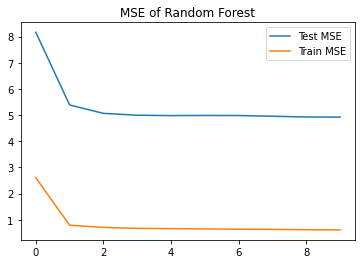

In [41]:
plt.plot(test_MSE, label='Test MSE')
plt.plot(train_MSE, label='Train MSE')
plt.legend()
plt.title("MSE of Random Forest")
plt.savefig("./MSE.jpg")

In [42]:
# 创建随机森林回归模型
rf_regressor = RandomForestRegressor(n_estimators=20, random_state=42)

# 训练模型
rf_regressor.fit(X_train, y_train)

# 预测
y_pred = rf_regressor.predict(X_test)

# 模型评估
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r2}')

Mean Squared Error (MSE): 5.081699430060766
R-squared: 0.8217648451133602
